# Estrazione Features per PatchCore

Questo notebook contiene il codice per:
1. Caricare e preprocessare le immagini dal dataset MVTec
2. Definire e utilizzare un estrattore di features basato su CNN
3. Estrarre patch dalle feature maps
4. Creare e popolare gli indici FAISS per la ricerca di anomalie

Il notebook è focalizzato sull'estrazione delle features e sulla preparazione dei dati per l'algoritmo PatchCore.

In [20]:
# Importa le librerie necessarie
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
from IPython.display import display, clear_output
import faiss
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter

# Aggiungi il percorso root per gli import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importa le funzioni personalizzate
from functions.utils import diagnose_gpu_cuda, check_cuda_availability, get_device

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

# Imposta il seed per riproducibilità
np.random.seed(42)
torch.manual_seed(42)

# Ottieni il device
device = get_device()
print(f"Utilizzo device: {device}")

Using device: cuda (NVIDIA GeForce RTX 3060 Ti)
Utilizzo device: cuda


In [21]:
# Definizione delle classi per il dataset e l'estrazione delle feature
# MVTec Dataset
class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, category, train=True, transform=None):
        self.transform = transform
        self.train = train
        path = os.path.join("../.dataset/mvtecad", category, "train" if train else "test")
        self.good_path = os.path.join(path, "good")
        self.image_paths = []
        self.labels = []
        self.subfolders = []

        if train:
            # Solo immagini good per il training
            self.image_paths = [os.path.join(self.good_path, f) for f in os.listdir(self.good_path) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
        else:
            # Per il test: crea sottocartelle per ogni tipo (comprese good)
            for defect_type in os.listdir(path):
                defect_path = os.path.join(path, defect_type)
                if os.path.isdir(defect_path):
                    files = [f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                    for f in files:
                        self.image_paths.append(os.path.join(defect_path, f))
                        self.labels.append(defect_type)
                        self.subfolders.append(defect_type)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img
        else:
            # Restituisci anche la sottocartella (defect_type) e il nome file
            file_name = os.path.basename(self.image_paths[idx])
            defect_type = self.subfolders[idx]
            return img, defect_type, file_name

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Feature Extractor
class AlternativeFeatureExtractor(nn.Module):
    def __init__(self, device):
        super(AlternativeFeatureExtractor, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.conv1.to(self.device)
        self.conv2.to(self.device)
        self.conv3.to(self.device)
        self.conv4.to(self.device)
        self.activate = torch.nn.functional

    def forward(self, x):
        x1 = self.activate.relu(self.conv1(x))
        x2 = self.activate.relu(self.conv2(x1))
        x3 = self.activate.relu(self.conv3(x2))
        x4 = self.activate.relu(self.conv4(x3))
        return x4, (x1, x2, x3, x4)  # Ritorna l'output finale e tutti gli output intermedi

    def get_all_features(self, x):
        """
        Estrae tutte le feature maps intermedie dal modello
        """
        x1 = self.activate.relu(self.conv1(x))
        x2 = self.activate.relu(self.conv2(x1))
        x3 = self.activate.relu(self.conv3(x2))
        x4 = self.activate.relu(self.conv4(x3))
        return {"conv1": x1, "conv2": x2, "conv3": x3, "conv4": x4}
    
# Classe PreTrainedFeatureExtractor: clone di AlternativeFeatureExtractor, ma con pesi pre-allenati da modelli solidi (es. ResNet, ImageNet)
import torchvision.models as models

class PreTrainedFeatureExtractor(nn.Module):
    def __init__(self, device, backbone='resnet18', pretrained=True):
        super(PreTrainedFeatureExtractor, self).__init__()
        self.device = device
        # Carica un backbone pre-allenato (es. ResNet)
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
        else:
            raise ValueError(f"Backbone {backbone} non supportato")
        # Usa solo i primi layer convoluzionali
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.conv1.to(self.device)
        self.bn1.to(self.device)
        self.layer1.to(self.device)
        self.layer2.to(self.device)
        self.layer3.to(self.device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        return x4, (x1, x2, x3, x4)

    def get_all_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        return {"conv1": x1, "conv2": x2, "conv3": x3, "conv4": x4}


In [22]:
# Funzioni di supporto per estrarre patch
def extract_compact_patches(
    features: torch.Tensor, 
    patch_size=5, 
    reduction='mean', 
    stride=1, 
    padding=0
    ) -> torch.Tensor:
    """
    Estrae patch da una feature map 4D usando sliding window (simile a una convoluzione), 
    con supporto per stride e padding.
    """
    # Applica padding se richiesto
    if padding > 0:
        features = torch.nn.functional.pad(features, (padding, padding, padding, padding))

    batch_size, channels, height, width = features.shape

    # Estrai patch con unfold su height e width
    patches = features.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # patches shape: (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Porta tutte le patch in una sola dimensione
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)  

    if reduction not in ['mean', 'max' , 'mean+max' , 'flatten']:
        raise ValueError("Reduction deve essere 'mean' o 'max'")
    if reduction == 'max':
        # Calcola il massimo su ogni patch per ogni canale
        patches_reduced = patches.amax(dim=[3, 4])
    if reduction == 'mean':
        # Calcola la media su ogni patch per ogni canale
        patches_reduced = patches.mean(dim=[3, 4])
    if reduction == 'mean+max':
        # Calcola la media e il massimo su ogni patch per ogni canale
        mean_patches = patches.mean(dim=[3, 4])
        max_patches = patches.amax(dim=[3, 4])
        # Combina mean e max concatenandoli lungo la dimensione dei canali
        patches_reduced = torch.cat((mean_patches, max_patches), dim=1)
    if reduction == 'flatten':
        # Appiattisce le patch in un vettore 1D
        patches_reduced = patches.view(batch_size, channels, -1)

    # Porta la dimensione dei canali in fondo: (batch, num_patches, channels)
    patches_reduced = patches_reduced.permute(0, 2, 1)

    # Unisci tutti i batch in una sola dimensione: (num_patches_totali, channels)
    patches_reduced = patches_reduced.reshape(-1, channels)

    return patches_reduced

def process_single_image_with_features(
    image, model, device, patch_size, stride, padding, reduction):
    """
    Elabora un'immagine, estrae le feature maps e le patch.
    Ritorna sia le patch che tutte le feature maps intermedie.
    """
    # Prepara l'immagine per il modello
    if isinstance(image, Image.Image):
        img = image.resize((256, 256))
        img_tensor = transform(img).unsqueeze(0).to(device)
    elif isinstance(image, np.ndarray):
        img = Image.fromarray(image.astype(np.uint8)).resize((256, 256))
        img_tensor = transform(img).unsqueeze(0).to(device)
    elif isinstance(image, torch.Tensor):
        if image.dim() == 3:
            img_tensor = image.unsqueeze(0).to(device)
        else:
            img_tensor = image.to(device)
    else:
        raise TypeError("Input deve essere PIL Image, NumPy array o torch.Tensor")
    
    # Estrai feature
    with torch.no_grad():
        feature_maps = model.get_all_features(img_tensor)
        final_features = feature_maps["conv4"] 
        patches = extract_compact_patches(final_features, 
                                         patch_size=patch_size, 
                                         stride=stride, 
                                         padding=padding, 
                                         reduction=reduction)
    
    return patches, feature_maps, img_tensor

In [23]:
# Carica il modello e l'indice FAISS dal notebook precedente
def load_model_and_faiss_index(category='tile'):
    """
    Carica il modello, il dataset e crea l'indice FAISS
    """
    # Inizializza il modello
    model = PreTrainedFeatureExtractor(device=device)
    model.to(device)
    model.eval()
    
    # Carica il dataset
    df = MVTecDataset(category=category, train=True, transform=transform)
    df_test = MVTecDataset(category=category, train=False, transform=transform)
    
    # Parametri
    patch_size = 3
    stride = 1
    padding = 0
    reduction = 'mean+max'
    number_of_images_for_training = 5  # Usa solo le prime 5 immagini per velocizzare
    
    print("Elaborazione delle immagini per creare l'indice FAISS...")
    
    # Estrai le feature da tutte le immagini di training (o da un sottoinsieme)
    # Per semplicità, qui estraiamo le feature solo da alcune immagini
    sample_indices = list(range(min(5, len(df))))  # Usa solo le prime 5 immagini
    all_patches_list = []
    
    for idx in sample_indices:
        image = df[idx]
        patches, _, _ = process_single_image_with_features(
            image, model, device, patch_size, stride, padding, reduction)
        all_patches_list.append(patches.cpu())
    
    all_extracted_patches = torch.cat(all_patches_list, dim=0)
    
    # Clustering con K-means per ridurre il numero di patch (sub-bank)
    k = 100  # Numero di cluster
    dimension = all_extracted_patches.shape[1]
    patches_for_kmeans = all_extracted_patches.cpu().numpy().astype('float32')
    
    print("Addestramento K-means per creare il sub-bank...")
    kmeans = faiss.Kmeans(dimension, k, niter=20, verbose=True, gpu=False)
    kmeans.train(patches_for_kmeans)
    
    # Assegna ogni patch a un cluster
    D, I = kmeans.index.search(patches_for_kmeans, 1)
    cluster_assignments = I[:, 0]
    
    # Crea il sub-bank selezionando il 5% da ogni cluster
    sub_bank_list = []
    percentage_to_select = 0.05
    
    for cluster_id in range(k):
        indices_in_cluster = np.where(cluster_assignments == cluster_id)[0]
        if len(indices_in_cluster) > 0:
            num_to_select = max(1, int(len(indices_in_cluster) * percentage_to_select))
            selected_indices = np.random.choice(indices_in_cluster, size=num_to_select, replace=False)
            sub_bank_list.append(torch.from_numpy(patches_for_kmeans[selected_indices]))
    
    sub_bank = torch.cat(sub_bank_list, dim=0)
    vectors = sub_bank.cpu().numpy().astype('float32')
    
    # Crea gli indici FAISS
    index_L2 = faiss.IndexFlatL2(vectors.shape[1])
    index_ip = faiss.IndexFlatIP(vectors.shape[1])
    
    # Aggiungi i vettori agli indici
    index_L2.add(vectors)
    index_ip.add(vectors)
    
    print(f"Indici FAISS creati. Numero di vettori: {index_L2.ntotal}")
    
    return model, index_L2, index_ip, df_test, vectors

d:\coding\pubblic\-CV---anomalib-tutorial-with-visualization\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\coding\pubblic\-CV---anomalib-tutorial-with-visualization\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Elaborazione delle immagini per creare l'indice FAISS...
Addestramento K-means per creare il sub-bank...
Indici FAISS creati. Numero di vettori: 406
label :glue_strip
image size : torch.Size([3, 256, 256])
Addestramento K-means per creare il sub-bank...
Indici FAISS creati. Numero di vettori: 406
label :glue_strip
image size : torch.Size([3, 256, 256])


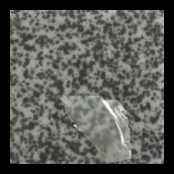

In [24]:
def show_test_image(idx):
    plt.figure(figsize=(2, 2))
    img_tensor = df_test[idx][0]
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()



model, index_L2, index_ip, df_test, vectors = load_model_and_faiss_index(category='tile')
index = 25
print(f"label :{df_test[index][1]}")
print(f"image size : {df_test[index][0].shape[:]}")  # (C, H, W)
show_test_image(index)


In [25]:
# ogni immagine ha dimensioni 3 x 256 x 256 (C, H, W)
# ogni immagine passa attraverso 4 layer convoluzionali con kernel 3x3, stride 1, padding 0
# le feature maps risultanti hanno dimensioni 16 x 254 x 254, 32 x 252 x 252, 64 x 250 x 250, 128 x 248 x 248
# estraiamo patch 3x3 con stride 1 e padding 0 dalla feature map finale (128 x 248 x 248)
# il numero totale di patch estratte sarà (248-3+1)*(248-3+1) = 246*246 = 60516
# ogni patch viene ridotta a un vettore di 128 dimensioni (media su 3x3)
# quindi otteniamo 60516 vettori di 128 dimensioni per immagine

# al contempo possiamo quindi dire che ogni singolo vettore di 128 dimensioni corrisponde a una patch 3x3 in una posizione specifica
# della feature map 128 x 248 x 248, che a sua volta corrisponde a una patch 5x5 nel layer precedente (64 x 250 x 250), che a sua volta
# corrisponde a una patch 7x7 nel layer precedente (32 x 252 x 252), che a sua volta corrisponde a una patch 9x9 nel layer precedente (16 x 254 x 254)
# e infine questa patch 9x9 corrisponde a una patch 11x11 nell'immagine originale (3 x 256 x 256)
# quindi ogni vettore di 128 dimensioni può essere mappato a una patch 11x11 nell'immagine originale

In [26]:
def get_valid_patch_centers(img_size=256, patch_size=11):
    """
    Restituisce una lista di tuple (y, x) che rappresentano le coordinate valide
    per il centro di una patch quadrata di dimensione patch_size x patch_size
    all'interno di un'immagine di dimensione img_size x img_size.
    """
    half = patch_size // 2
    coords = []
    for y in range(half, img_size - half):
        for x in range(half, img_size - half):
            coords.append((y, x))
    return coords

# Esempio d'uso:
valid_centers = get_valid_patch_centers(img_size=256, patch_size=11)
print(f"Numero di centri validi: {len(valid_centers)}")
print(f"coordinate dei centri per le zone estreme agli angoli iniziali e finali: {valid_centers[0]}, {valid_centers[-1]}")  # Primo e ultimo centro valido

Numero di centri validi: 60516
coordinate dei centri per le zone estreme agli angoli iniziali e finali: (5, 5), (250, 250)


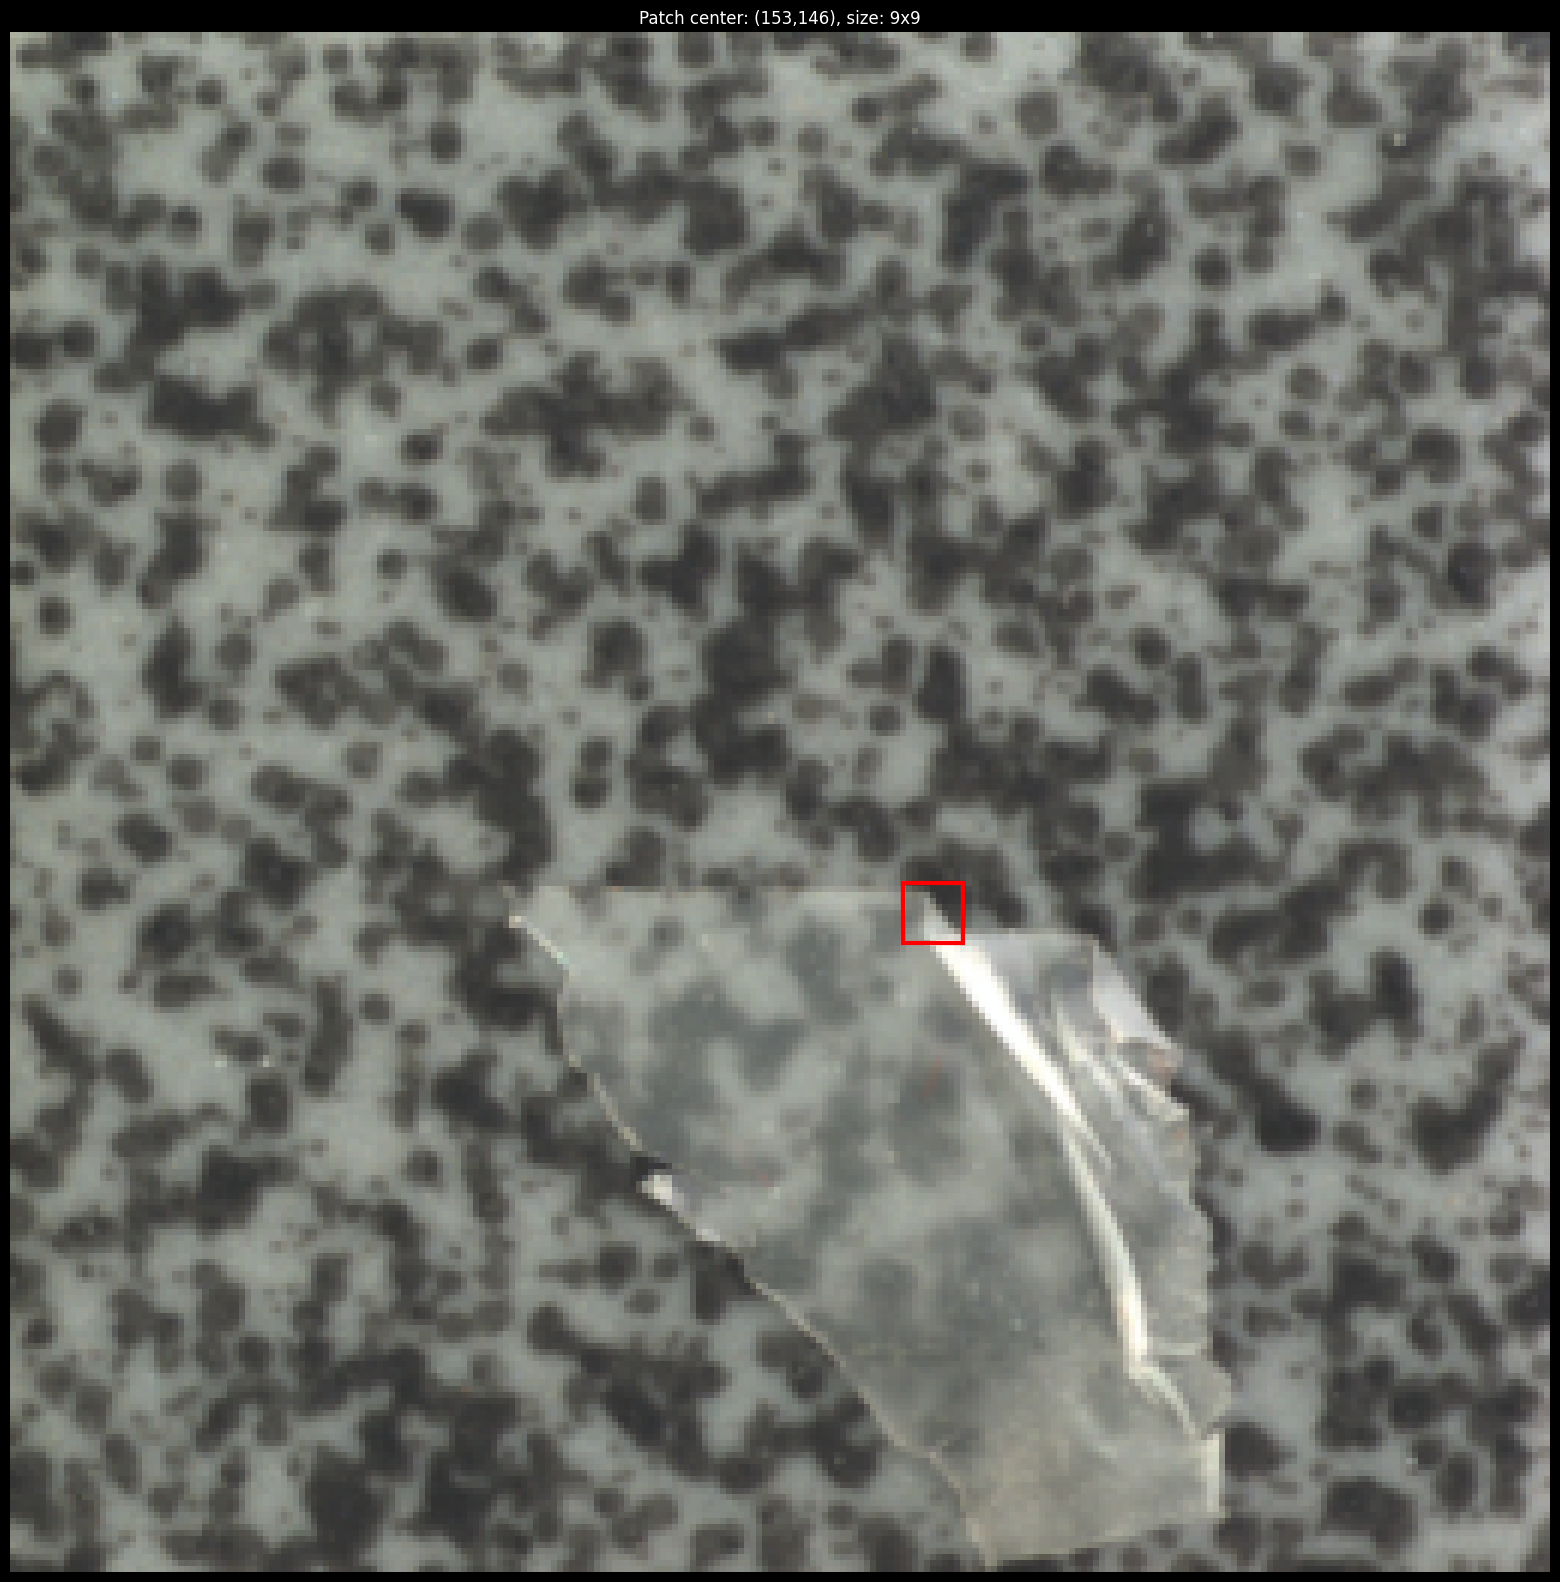

In [27]:
from matplotlib.patches import Rectangle

def plot_patch_on_test_image(df_test, idx, patch_size, center):
    """
    Mostra l'immagine df_test[idx] con una patch centrata in 'center' (x, y) e dimensione patch_size x patch_size,
    evidenziata da un rettangolo rosso. Il rettangolo deve coprire [y-half-1 : y+half+1, x-half-1 : x+half+1].
    """

    # Estrai immagine e converti in numpy per visualizzazione
    img_tensor = df_test[idx][0]
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    valid_centers = get_valid_patch_centers(img_size=img_np.shape[0], patch_size=patch_size)

    x, y = center
    if (y, x) not in valid_centers:
        raise ValueError(f"Center {center} is not valid for patch size {patch_size}. Valid centers range from {valid_centers[0]} to {valid_centers[-1]}.")
    half = patch_size // 2 

    # Calcola i limiti del rettangolo (inclusivi)
    top = y - half - 1
    left = x - half - 1
    width = patch_size + 1
    height = patch_size + 1

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(img_np)
    rect = Rectangle((left, top), width, height, linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(f'Patch center: ({x},{y}), size: {patch_size}x{patch_size}')
    ax.axis('off')
    plt.show()

plot_patch_on_test_image(df_test, index, patch_size=9, center=(153, 146))

scrivi una nuova funzione che prenda in ingresso gli stessi parametri di plot_patch_on_test_image

voglio che plotti un subplot con:
- immagine originale zoommata nella zona selezionata con il riquadro rosso ( se la patch_size è 9x9 voglio che l'area visualizzata sia 27x27)

- rappresentazione 3d della relativa patch selezionata in scala di grigi ( sarà una 11x11x3 , usa dei cubi in scala di grigio per rappresentare i singoli elementi di ogni vettore)

-rappresentazione 3d della patch dopo conv1 (sarà quindi una 9x9x16)

-rappresentazione 3d dopo conv2 conv3 e conv4

usa pure matplotlib

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_tensor_cubes_patch_rgb(ax, tensor, title=None):
    """
    Visualizza un tensore 11x11x3 come cubi colorati RGB.
    """
    H, W, D = tensor.shape
    x, y, z = np.indices((H, W, D))
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = tensor.flatten()
    for xi, yi, zi, val in zip(x, y, z, values):
        # Colore RGB: ogni canale z ha il suo colore
        if zi == 0:
            color = (val, 0, 0)  # Rosso
        elif zi == 1:
            color = (0, val, 0)  # Verde
        elif zi == 2:
            color = (0, 0, val)  # Blu
        else:
            color = (val, val, val)
        ax.bar3d(xi, yi, zi, 0.8, 0.8, 0.8, color=color, shade=True, alpha=1)
    ax.set_xticks(np.arange(H) + 0.4)
    ax.set_yticks(np.arange(W) + 0.4)
    ax.set_zticks(np.arange(D) + 0.4)
    ax.set_xticklabels([str(i) for i in range(H)])
    ax.set_yticklabels([str(i) for i in range(W)])
    ax.set_zticklabels(['R','G','B'])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('Canale')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax.grid(False)
    if title:
        ax.set_title(title)

def plot_tensor_cubes_patch(ax, tensor, title=None, mode='plasma', rgb_colors=None):
    """
    Visualizza un tensore 3D come cubi colorati su un axis esistente.
    mode: 'plasma' per colormap plasma, 'gray' per scala di grigi, oppure usa rgb_colors per colorare ogni cubo.
    """
    H, W, D = tensor.shape
    x, y, z = np.indices((H, W, D))
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = tensor.flatten()
    for idx, (xi, yi, zi, val) in enumerate(zip(x, y, z, values)):
        if rgb_colors is not None and D == 1:
            # rgb_colors deve essere HxWx3, prendi il colore per ogni pixel
            color = tuple(rgb_colors[yi, xi])
        elif mode == 'gray':
            color = (val, val, val)
        else:
            color = cm.plasma(val)[:3]
        ax.bar3d(xi, yi, zi, 0.8, 0.8, 0.8, color=color, shade=True, alpha=1)
    ax.set_xticks(np.arange(H) + 0.4)
    ax.set_yticks(np.arange(W) + 0.4)
    ax.set_zticks(np.arange(D) + 0.4)
    ax.set_xticklabels([str(i) for i in range(H)])
    ax.set_yticklabels([str(i) for i in range(W)])
    ax.set_zticklabels([str(i) for i in range(D)])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax.grid(False)
    if title:
        ax.set_title(title)

def visualize_patch_through_network(df_test, idx, patch_size, center, model, device, zoom_factor=3 , normalize=True ):
    """
    Visualizza il percorso di un patch attraverso la rete neurale con rappresentazioni 2D e 3D.
    Riga 1: immagine intera con riquadro rosso, zona zoommata con riquadro rosso.
    Riga 2: patch 11x11x1 (3D, colore RGB medio per pixel), patch 11x11x3 (RGB 3D), Conv1 9x9x16 (plasma).
    Riga 3: Conv2 7x7x32, Conv3 5x5x64, Conv4 3x3x128 (tutte plasma).
    """

    img_tensor = df_test[idx][0].to(device)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    with torch.no_grad():
        feature_maps = model.get_all_features(img_tensor.unsqueeze(0))

    if (center[1], center[0]) not in get_valid_patch_centers(img_size=img_np.shape[0], patch_size=patch_size):
        raise ValueError(f"Center {center} is not valid for patch size {patch_size}.")
    
    x, y = center
    half_patch = patch_size // 2
    zoom_factor = 3
    zoom_size = patch_size * zoom_factor
    half_zoom = zoom_size // 2
    y_zoom_start = max(0, y - half_zoom)
    y_zoom_end = min(img_np.shape[0], y + half_zoom + 1)
    x_zoom_start = max(0, x - half_zoom)
    x_zoom_end = min(img_np.shape[1], x + half_zoom + 1)
    zoomed_region = img_np[y_zoom_start:y_zoom_end, x_zoom_start:x_zoom_end, :]

    patch_titles = [
        "Patch 11x11x1 (3D, colore RGB)",
        "Patch RGB 11x11x3 (3D)",
        "Conv1 9x9x16",
        "Conv2 7x7x32",
        "Conv3 5x5x64",
        "Conv4 3x3x128"
    ]

    # Estrazione patch dall'immagine originale
    y_start = max(0, y - 5)
    y_end = min(img_np.shape[0], y + 6)
    x_start = max(0, x - 5)
    x_end = min(img_np.shape[1], x + 6)
    patch_img = img_np[y_start:y_end, x_start:x_end, :]
    patch_img_norm = (patch_img - patch_img.min()) / (patch_img.max() - patch_img.min() + 1e-10)

    # Patch 11x11x1 (valore medio per pixel, ma colore RGB originale)
    patch_gray_3d = np.mean(patch_img, axis=2)[..., np.newaxis]
    patch_rgb_colors = np.transpose(patch_img, (1, 0, 2))  # Trasposta per visualizzazione corretta

    # Estrazione patch dalle feature maps
    def extract_patch(fm, size):
        c, h, w = fm.shape[1], fm.shape[2], fm.shape[3]
        center_y = h // 2
        center_x = w // 2
        half = size // 2
        y_start = max(0, center_y - half)
        y_end = min(h, center_y + half + 1)
        x_start = max(0, center_x - half)
        x_end = min(w, center_x + half + 1)
        return fm[0, :, y_start:y_end, x_start:x_end].cpu().numpy()

    patch_conv1 = extract_patch(feature_maps['conv1'], 9)
    patch_conv2 = extract_patch(feature_maps['conv2'], 7)
    patch_conv3 = extract_patch(feature_maps['conv3'], 5)
    patch_conv4 = extract_patch(feature_maps['conv4'], 3)

    final_patch = patch_conv4.copy()  # Salva la patch finale 3x3x128

    def norm_patch(p):
        p = p.copy()
        p = (p - p.min()) / (p.max() - p.min() + 1e-10)
        return p
    
    # Normalizza le patch se richiesto

    if normalize:

        patch_img_norm = norm_patch(patch_img_norm)
        patch_conv1 = norm_patch(patch_conv1)
        patch_conv2 = norm_patch(patch_conv2)
        patch_conv3 = norm_patch(patch_conv3)
        patch_conv4 = norm_patch(patch_conv4)

    # Trasponi le patch per avere (H, W, C)

    patch_conv1_transposed = patch_conv1.transpose(1,2,0)
    patch_conv2_transposed = patch_conv2.transpose(1,2,0)
    patch_conv3_transposed = patch_conv3.transpose(1,2,0)
    patch_conv4_transposed = patch_conv4.transpose(1,2,0)

    # Crea subplot: 3 righe, 3 colonne
    fig = plt.figure(figsize=(22, 15))

    # --- Riga 1: immagini centrali tra le colonne ---
    # Definisci le posizioni manualmente (left, bottom, width, height)
    ax_img = fig.add_axes([0.22, 0.72, 0.22, 0.22])  # Centra tra 0 e 1
    ax_img.imshow(img_np)
    x_vertex = x_start - 1
    y_vertex = y_start - 1
    width = patch_size + 1
    height = patch_size + 1
    rect = plt.Rectangle((x_vertex, y_vertex), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax_img.add_patch(rect)
    ax_img.set_title('Immagine originale con patch')
    ax_img.axis('off')

    ax_zoom = fig.add_axes([0.56, 0.72, 0.22, 0.22])  # Centra tra 1 e 2
    ax_zoom.imshow(zoomed_region)
    patch_x_in_zoom = (x - x_zoom_start) - 5 - 1
    patch_y_in_zoom = (y - y_zoom_start) - 5 - 1
    rect_zoom = plt.Rectangle((patch_x_in_zoom, patch_y_in_zoom), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax_zoom.add_patch(rect_zoom)
    ax_zoom.set_title('Zona zoommata con patch')
    ax_zoom.axis('off')

    # --- Riga 2: patch 3D con colore RGB medio, patch RGB 3D, Conv1 ---
    ax_gray_3d = fig.add_subplot(3, 3, 4, projection='3d')
    plot_tensor_cubes_patch(ax_gray_3d, patch_gray_3d, patch_titles[0], rgb_colors=patch_rgb_colors)

    ax_rgb = fig.add_subplot(3, 3, 5, projection='3d')
    plot_tensor_cubes_patch_rgb(ax_rgb, patch_img_norm, patch_titles[1])

    ax1 = fig.add_subplot(3, 3, 6, projection='3d')
    plot_tensor_cubes_patch(ax1, patch_conv1_transposed, patch_titles[2], mode='plasma')

    # --- Riga 3: Conv2, Conv3, Conv4 ---
    ax2 = fig.add_subplot(3, 3, 7, projection='3d')
    plot_tensor_cubes_patch(ax2, patch_conv2_transposed, patch_titles[3], mode='plasma')

    ax3 = fig.add_subplot(3, 3, 8, projection='3d')
    plot_tensor_cubes_patch(ax3, patch_conv3_transposed, patch_titles[4], mode='plasma')

    ax4 = fig.add_subplot(3, 3, 9, projection='3d')
    plot_tensor_cubes_patch(ax4, patch_conv4_transposed, patch_titles[5], mode='plasma')

    plt.tight_layout()
    plt.show()
    return torch.tensor(final_patch) # ritorna la patch finale 3x3x128

C:\Users\sebas\AppData\Local\Temp\ipykernel_32808\2648105522.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\sebas\AppData\Local\Temp\ipykernel_32808\2648105522.py:221: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\sebas\AppData\Local\Temp\ipykernel_32808\2648105522.py:221: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


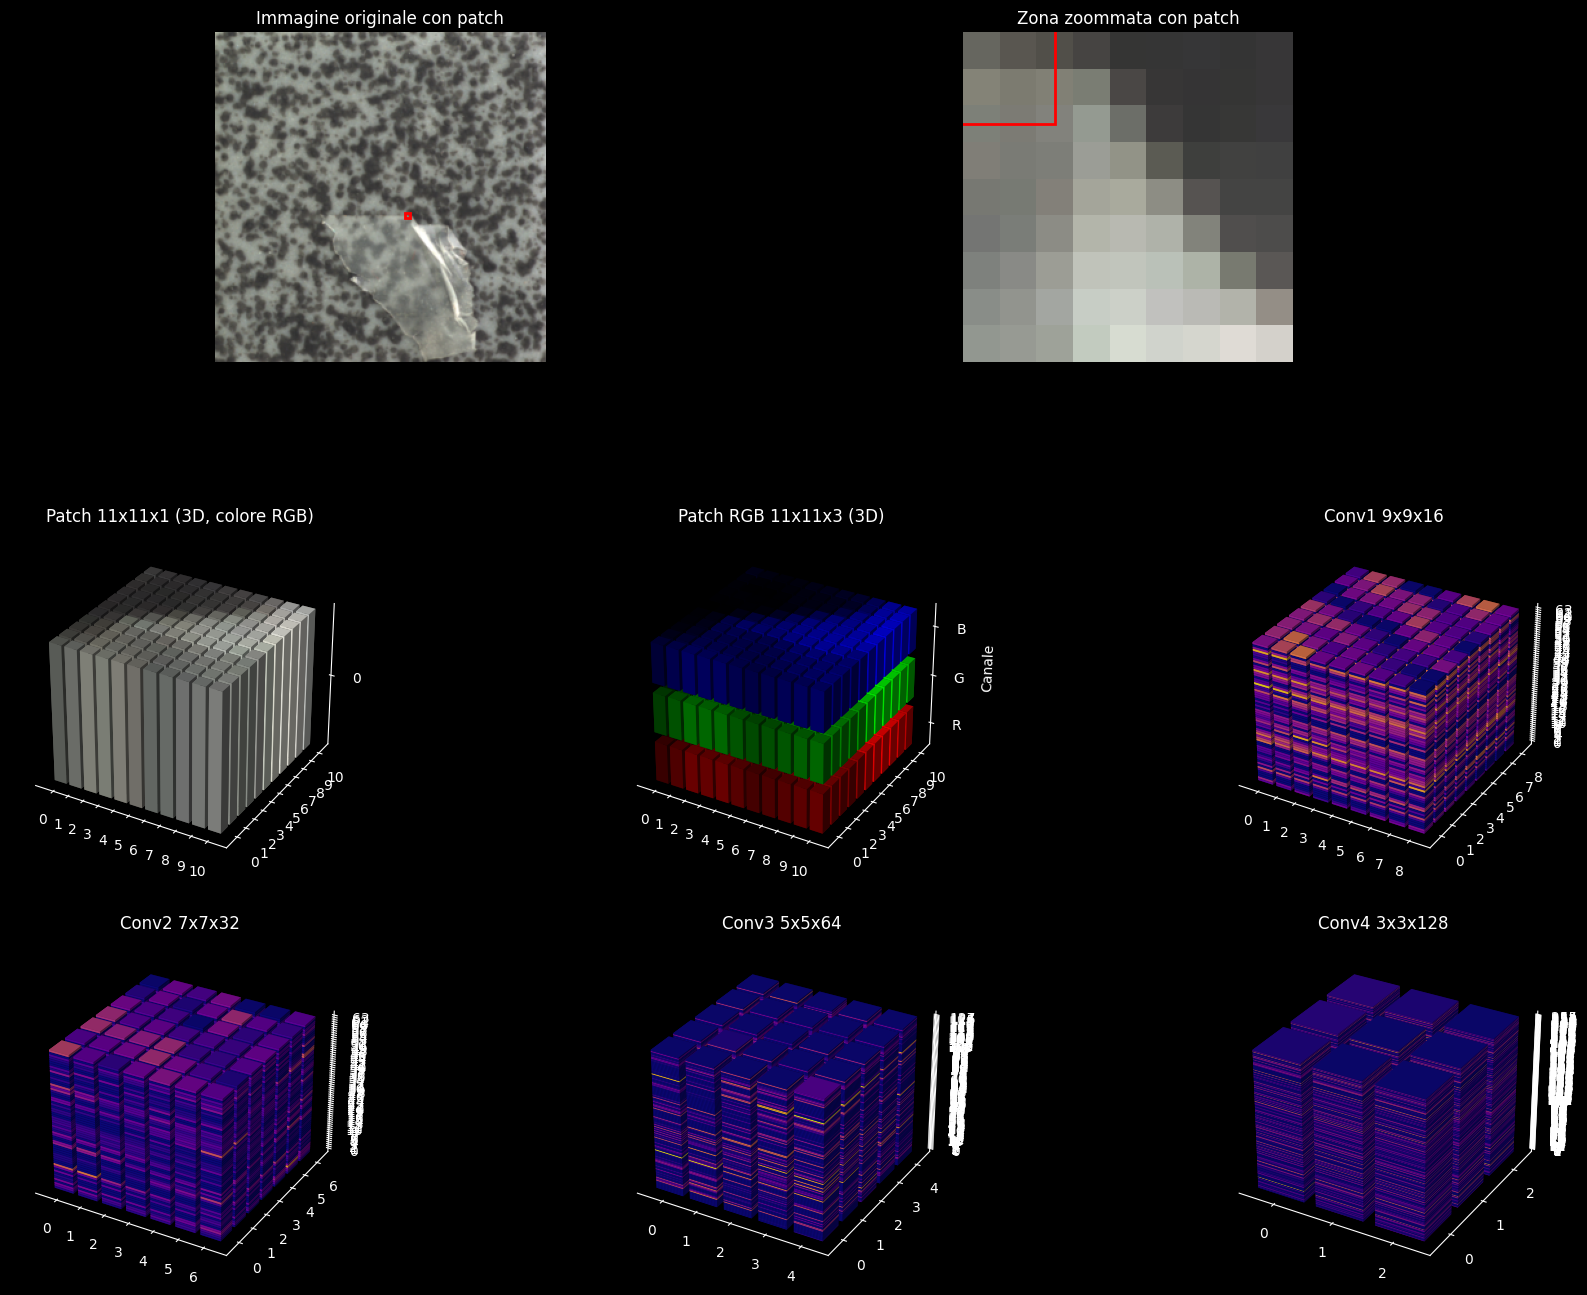

In [29]:
# Esempio di utilizzo della funzione
# Visualizza il percorso di un patch attraverso la rete neurale
final_patch = visualize_patch_through_network(
    df_test=df_test,
    idx=index,             # Indice dell'immagine di test
    patch_size=3,         # Dimensione del patch (11x11)
    center=(153, 146),     # Centro del patch (x, y)
    model=model,           # Modello neurale
    device=device,         # Device (CPU/GPU)
    zoom_factor=3,         # Fattore di zoom (area visualizzata = patch_size * zoom_factor)
    normalize=True        # Normalizza le patch per una migliore visualizzazione
);

In [30]:
def find_faiss_neighbors(tensor, index_L2, index_ip, k=3 , reduction='mean'):
    """
    Trova i k vicini più vicini utilizzando entrambi i modelli FAISS (L2 e IP).
    
    Args:
        tensor (numpy.ndarray): Tensore di dimensione 3x3x128.
        index_L2 (faiss.IndexFlatL2): Modello FAISS per distanza L2.
        index_ip (faiss.IndexFlatIP): Modello FAISS per prodotto scalare.
        k (int): Numero di vicini da trovare.
    
    Returns:
        dict: Dizionario con i risultati per entrambi i modelli.
              Chiavi: 'L2' e 'IP'.
              Valori: Tuple contenenti (distanze, indici).
    """

    if reduction not in ['mean', 'max' , 'mean+max' , 'flatten']:
        raise ValueError("Reduction deve essere 'mean' o 'max'")
    if reduction == 'max':
        # Calcola il massimo su ogni patch per ogni canale
        tensor_reduced = tensor.amax(dim=[1, 2])
    if reduction == 'mean':
        # Calcola la media su ogni patch per ogni canale
        tensor_reduced = tensor.mean(dim=[1, 2])
    if reduction == 'mean+max':
        # Calcola la media e il massimo su ogni patch per ogni canale
        mean_patches = tensor.mean(dim=[1, 2])
        max_patches = tensor.amax(dim=[1, 2])
        # Combina mean e max concatenandoli lungo la dimensione dei canali
        tensor_reduced = torch.cat((mean_patches, max_patches), dim=0)
    if reduction == 'flatten':
        # Appiattisce le patch in un vettore 1D
        tensor_reduced = tensor.flatten()

    print(f"Vettore ridotto shape: {tensor_reduced.shape}")

    # Assicurati che il vettore sia di tipo float32 per FAISS e abbia la forma corretta
    reduced_tensor = tensor_reduced.cpu().numpy().astype('float32').reshape(1, -1)

    # Trova i vicini più vicini per L2
    distances_L2, indices_L2 = index_L2.search(reduced_tensor, k)

    # Trova i vicini più vicini per IP
    distances_IP, indices_IP = index_ip.search(reduced_tensor, k)

    print(f"Vettore di input shape: {reduced_tensor.shape}")

    return {
        'L2': (distances_L2, indices_L2),
        'IP': (distances_IP, indices_IP)
    }

# Esempio di utilizzo
# Ensure final_patch has the correct shape (3x3x128)
# reshaped_patch = final_patch.permute(1, 2, 0)  # Reshape from (128, 3, 3) to (3, 3, 128)

neighbors = find_faiss_neighbors(final_patch, index_L2, index_ip, k=3 , reduction='mean')
# Stampa i risultati per L2
distances_L2, indices_L2 = neighbors['L2']
print("Vicini L2:")
print("Distanze:", distances_L2)
print("Indici:", indices_L2)

# Stampa i risultati per IP
distances_IP, indices_IP = neighbors['IP']
print("\nVicini IP:")
print("Distanze:", distances_IP)
print("Indici:", indices_IP)

Vettore ridotto shape: torch.Size([256])
Vettore di input shape: (1, 256)
Vicini L2:
Distanze: [[0.7234407  0.75684166 0.79353046]]
Indici: [[49 48 37]]

Vicini IP:
Distanze: [[16.979795 16.922878 16.144358]]
Indici: [[178  13 183]]


In [31]:
neighbors = find_faiss_neighbors(final_patch, index_L2, index_ip, k=3 ,reduction='max')
# Stampa i risultati per L2
distances_L2, indices_L2 = neighbors['L2']
print("Vicini L2:")
print("Distanze:", distances_L2)
print("Indici:", indices_L2)

# Stampa i risultati per IP
distances_IP, indices_IP = neighbors['IP']
print("\nVicini IP:")
print("Distanze:", distances_IP)
print("Indici:", indices_IP)

Vettore ridotto shape: torch.Size([256])
Vettore di input shape: (1, 256)
Vicini L2:
Distanze: [[3.0877233 3.1357112 3.1946025]]
Indici: [[175 120 363]]

Vicini IP:
Distanze: [[26.201561 26.173407 25.018635]]
Indici: [[ 13 178  18]]


In [32]:
# per 'mean+max' e 'flatten' la dimensione del vettore raddoppia o aumenta notevolmente
# ed è essenziale che l'indice FAISS sia stato creato con la stessa riduzione
# altrimenti si otterranno errori di dimension mismatch

neighbors = find_faiss_neighbors(final_patch, index_L2, index_ip, k=3 , reduction='mean+max')
# Stampa i risultati per L2
distances_L2, indices_L2 = neighbors['L2']
print("Vicini L2:")
print("Distanze:", distances_L2)
print("Indici:", indices_L2)

# Stampa i risultati per IP
distances_IP, indices_IP = neighbors['IP']
print("\nVicini IP:")
print("Distanze:", distances_IP)
print("Indici:", indices_IP)

Vettore ridotto shape: torch.Size([512])


AssertionError: 

In [35]:
img_tensor = df_test[10][0].to(device)
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_np = np.clip(img_np, 0, 1)
with torch.no_grad():
    feature_maps = model.get_all_features(img_tensor.unsqueeze(0))

In [37]:
feature_maps['conv1'].shape , feature_maps['conv2'].shape , feature_maps['conv2'].shape , feature_maps['conv4'].shape 

(torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 256, 32, 32]))

In [38]:
model

PreTrainedFeatureExtractor(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi